In [2]:
import sys
sys.path.append("BCNN-SCP")

import torch
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

from src.main import LightningModule

# Load checkpoint
path = "checkpoints/BCNN RBF(100, 0.1) U(0.1,0.3) a=100.0 l=1.0 k=RBF/last.ckpt"
ckpt = torch.load(path, weights_only=False)
config = ckpt["hyper_parameters"]["config"]
weights = ckpt["state_dict"]

# Load model
model = LightningModule(config)
model.load_state_dict(weights)
model.eval()

# Load dataset
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize((config["data"]["normalize_mean"],), (config["data"]["normalize_std"],))
])
dataset = datasets.MNIST(root='data', train=False, transform=transform, download=False)

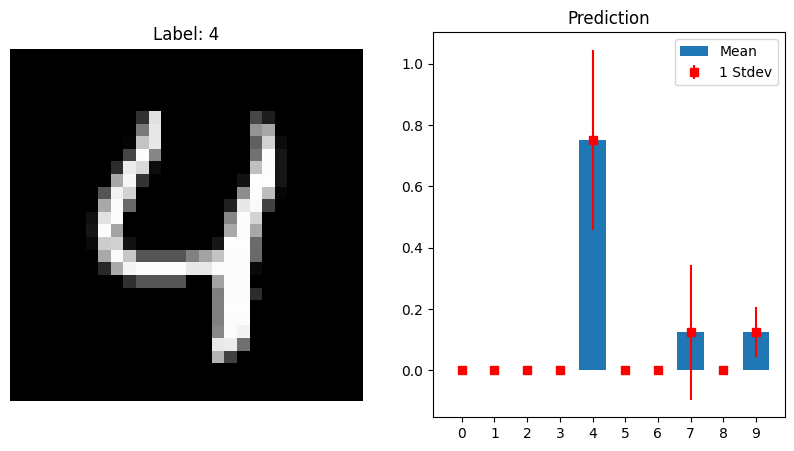

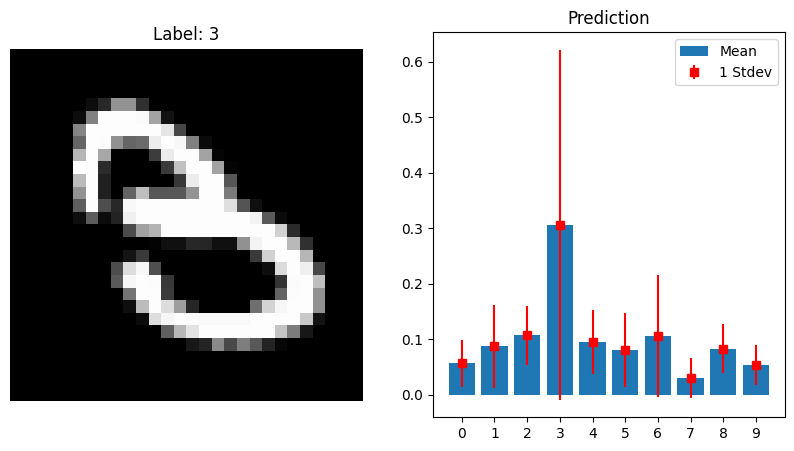

In [ ]:
# Helper function to visualize prediction
def visualize_prediction(index):
    # Fix seed for reproducibility
    torch.manual_seed(42)

    # Get image and label
    image, label = dataset[index]

    # Get prediction
    probs = model.predict(image) # (n_samples, n_classes)

    # Create figure
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    # Visualize image
    # Denormalize for visualization
    image = image * config["data"]["normalize_std"] + config["data"]["normalize_mean"]
    image = image[0] # Grayscale image
    axs[0].imshow(image, cmap='gray')
    axs[0].axis('off')
    axs[0].set_title(f"Label: {label}")

    # Visualize prediction
    probs_mean = probs.mean(dim=0)
    probs_std = probs.std(dim=0)
    axs[1].bar(range(10), probs_mean, label="Mean")
    axs[1].errorbar(range(10), probs_mean, yerr=probs_std, fmt='rs', label="1 Stdev")
    axs[1].legend()
    axs[1].set_xticks(range(10))
    axs[1].set_title("Prediction")

visualize_prediction(4)
visualize_prediction(18)